In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters as plotters
import Learning.training_data as training_data

%load_ext autoreload
%autoreload 2

/home/kian/anaconda3/envs/thesis2/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters.LUMPED_PARAMETERS
print(rp)
import Plotting.theta_visualiser as theta_visualizer

mapping_functions = (transforms.analytic_theta_1, transforms.analytic_theta_2)
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, mapping_functions=mapping_functions)
#th_plotter.make_figure("theta_subset_5_2_image.png")
#th_plotter.make_animation("theta_subset_5_2.mp4", duration = 4, fps = 20, stride = 1)

cpu
{'l1': 3.1, 'l2': 2.0, 'm': 3.0, 'g': 9.81, 'xa': 5.0, 'ya': 2.0}


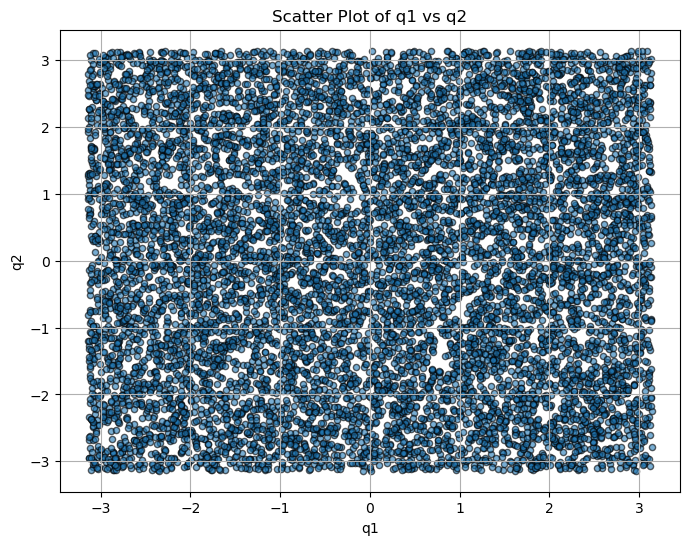

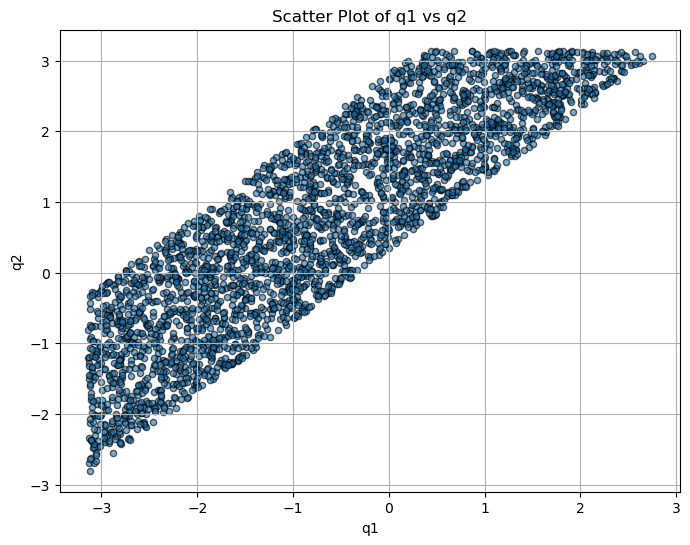

In [3]:
import numpy as np


# Retrieve training points
points = training_data.points.to(device)

# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()


valid_mask = ((points[:,1] >= points[:,0] + torch.pi * 1/10) & (points[:,1] <= points[:,0] + torch.pi * 9/10))
points = points[valid_mask]
points = points[0:3000]

plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [4]:
# Compute mass- and input matrix of all training points to reduce load in training

data_pairs = []
for point in points:
    Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
    Aq_point = dynamics.input_matrix(rp, point)
    data_pairs.append((point, Mq_point, Aq_point))


points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

# Create TensorDataset
dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
print(len(dataset))

2972


In [5]:
# Split into training and test sets (80% train, 20% test)

batch_size = 512
train_part = 0.7

train_size = int(train_part * len(points))
val_size = len(points) - train_size


# Create TensorDataset for both training and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the DataLoader for both training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


##Iterate through the DataLoader
#for batch in train_dataloader:
    #print(batch[0])
    #break  # Just to show one batch

In [28]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.Softplus(),
            nn.Linear(8, 8),
            nn.Softplus(),
            nn.Linear(8, 1)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.Softplus(),
            nn.Linear(8, 8),
            nn.Softplus(),
            nn.Linear(8, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2
    
        
    def theta_ana(self, q):
        theta_1_ana, _ = torch.vmap(self.encoder_theta_1_ana)(q)
        theta_2_ana, _ = torch.vmap(self.encoder_theta_2_ana)(q)
        theta_ana = torch.cat((theta_1_ana, theta_2_ana), dim=1)
        return theta_ana
    
    def theta_1_single(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1

    def encoder_nn(self, q):
        theta_2 = self.encoder(q)
        return theta_2, theta_2
    
    def theta_2_single(self, q):
        theta_2 = self.encoder(q)
        return theta_2
    
    def decoder_nn(self, theta):
        q_hat = self.decoder(theta)
        return q_hat, q_hat
    
    def forward(self, q):
        
        J_h_1, theta_1 = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        
        J_h_2, theta_2 = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)


        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        
        theta = torch.stack((theta_1, theta_2), dim=1).squeeze(2)
        J_h = torch.cat((J_h_1, J_h_2), dim=1).float()
        J_h_ana = torch.cat((J_h_1.float(), J_h_2_ana.float()), dim=1)

        J_h_dec, q_hat = torch.vmap(torch.func.jacfwd(self.decoder_nn, has_aux=True))(theta)
        J_h_dec = J_h_dec.float()

        return(theta, J_h, q_hat, J_h_dec, J_h_ana)

In [29]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)
load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 501

print(file_path)

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202501151444.pth
CPU times: user 2.21 ms, sys: 4 μs, total: 2.21 ms
Wall time: 1.91 ms


In [30]:
import torch.nn.functional as F

def loss_fun(q, q_hat, m_matrix, input_matrix, J_h, J_h_dec):
    l_recon = F.mse_loss(q, q_hat, reduction="sum")
    J_h_inv = J_h_dec
    J_h_trans = torch.transpose(J_h, 1, 2)
    J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

    J_ortho = J_h @ J_h_trans
    J_ortho_inv = J_h_inv @ J_h_inv_trans
    
    #identity_matrix = J_h @ J_h_inv  # Batch-wise multiplication
    #unitary_target = torch.eye(identity_matrix.size(-1), device=identity_matrix.device).expand(identity_matrix.size(0), -1, -1)


    # Enforce that decoder Jacobian is the inverse of the encoder Jacobian
    ## USE ONLY WHEN J_h_inv == J_h_dec
    #l_J_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2)  # Frobenius norm
    #l_J_ortho_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - J_ortho_inv)**2)  # Frobenius norm\n",

    # Enforce that the Jacobian is orthogonal
    l_J_ortho = torch.sum((torch.eye(J_ortho.size(-1), device=J_ortho.device) - J_ortho)**2)  # Frobenius norm

    diag_matrix = J_h_inv_trans @ m_matrix @ J_h_inv  # Batch-wise diagonalization

    ## Enforce inertial decoupling (diagonal loss)
    #off_dia = diag_matrix[:, 0, 1] 
    #trace = torch.einsum('bii->b', diag_matrix)
    #M_th_ratio = (off_dia/trace)
    #l_diag = nn.MSELoss()(M_th_ratio, torch.zeros((M_th_ratio.size())).to(device))

    
    # Enforce inertial decoupling
    ## Slight concern is that this sends all values of M_th to 0. Hopefully l_J_ortho avoids this
    # NOTE: This is a very inefficient way of just taking the off diagonal value, squaring it and doubling it
    dia_mask = torch.eye(2).unsqueeze(0).repeat(diag_matrix.size(0), 1, 1)
    l_diag = torch.sum((diag_matrix - diag_matrix * dia_mask)**2)  # Penalize off-diagonal terms

    ## input decoupling loss
    input_x = J_h_inv_trans @ input_matrix
    l_input = torch.sum((input_x[:, 1]**2)) #+ torch.sum(((input_x[:, 0]-1)**2))
    loss = l_recon + l_diag + l_input + l_J_ortho #+ l_J_inv + l_J_ortho_inv
    loss_terms = torch.tensor([l_recon, l_J_ortho, l_diag, l_input])

    return loss, loss_terms

In [31]:
outputs = []
plt.ion()

train_losses = []
val_losses = []
start_time = time.time()

model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))


for epoch in range(num_epochs):

    # Training phase
    model.train()
    train_loss = 0
    train_loss_terms = torch.zeros(4)

    for index, (q, M_q, A_q) in enumerate(train_dataloader):
        #batch_size = batch[0].shape[0]
        q = q.to(device)
        #q.requires_grad = True
        #q_d = batch[0].to(device)

        M_q = M_q.to(device)
        A_q = A_q.to(device)
        
        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)  
        theta_ana = model.theta_ana(q)
                
        loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)
        #loss, loss_terms = loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss_terms += loss_terms
    train_loss /= len(train_dataloader.dataset)
    train_loss_terms /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    val_loss_terms = torch.zeros(4)
    with torch.no_grad():
      for index, (q, M_q, A_q) in enumerate(val_dataloader):
        q = q.to(device)
        M_q = M_q.to(device)
        A_q = A_q.to(device)

        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
        theta_ana = model.theta_ana(q)

        loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)
        #loss, loss_terms = loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec)

        J_h_inv = torch.linalg.inv(J_h)
        J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
        M_th = J_h_inv_trans @ M_q @ J_h_inv 

        val_loss += loss.item()
        val_loss_terms += loss_terms
    val_loss /= len(val_dataloader.dataset)
    val_loss_terms /= len(val_dataloader.dataset)
    val_losses.append(val_loss)

    epoch_duration = time.time() - start_time
    scheduler.step()


    if epoch % 10 == 0:
        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds'
            )

        print(
            f"recon: {val_loss_terms[0].item():.4f}, "
            f"J_ortho: {val_loss_terms[1].item():.4f}, "
            f"diag: {val_loss_terms[2].item():.4f}, "
            f"input: {val_loss_terms[3].item():.4f}"
        )
        print(M_th[0])

#torch.save(model.state_dict(), file_path)
#print(f"Model parameters saved to {file_path}")

Epoch [1/501], Training Loss: 49.3503, Validation Loss: 48.0148, Duration: 0.14 seconds
recon: 5.1797, J_ortho: 42.8334, diag: 0.0004, input: 0.0014
tensor([[7.1438e+00, 4.0819e+02],
        [4.0819e+02, 4.0209e+04]])
Epoch [11/501], Training Loss: 46.7527, Validation Loss: 46.3307, Duration: 1.67 seconds
recon: 3.5121, J_ortho: 42.8156, diag: 0.0029, input: 0.0001
tensor([[1.0617e+01, 1.5541e+03],
        [1.5541e+03, 3.1711e+05]])
Epoch [21/501], Training Loss: 46.6846, Validation Loss: 46.2596, Duration: 3.35 seconds
recon: 3.4430, J_ortho: 42.8155, diag: 0.0008, input: 0.0003
tensor([[7.7318e+00, 8.8593e+02],
        [8.8593e+02, 1.6587e+05]])
Epoch [31/501], Training Loss: 46.6532, Validation Loss: 46.2298, Duration: 5.04 seconds
recon: 3.4130, J_ortho: 42.8153, diag: 0.0012, input: 0.0003
tensor([[6.2638e+00, 5.4474e+02],
        [5.4474e+02, 9.0920e+04]])
Epoch [41/501], Training Loss: 46.6305, Validation Loss: 46.1980, Duration: 6.80 seconds
recon: 3.3819, J_ortho: 42.8147, dia

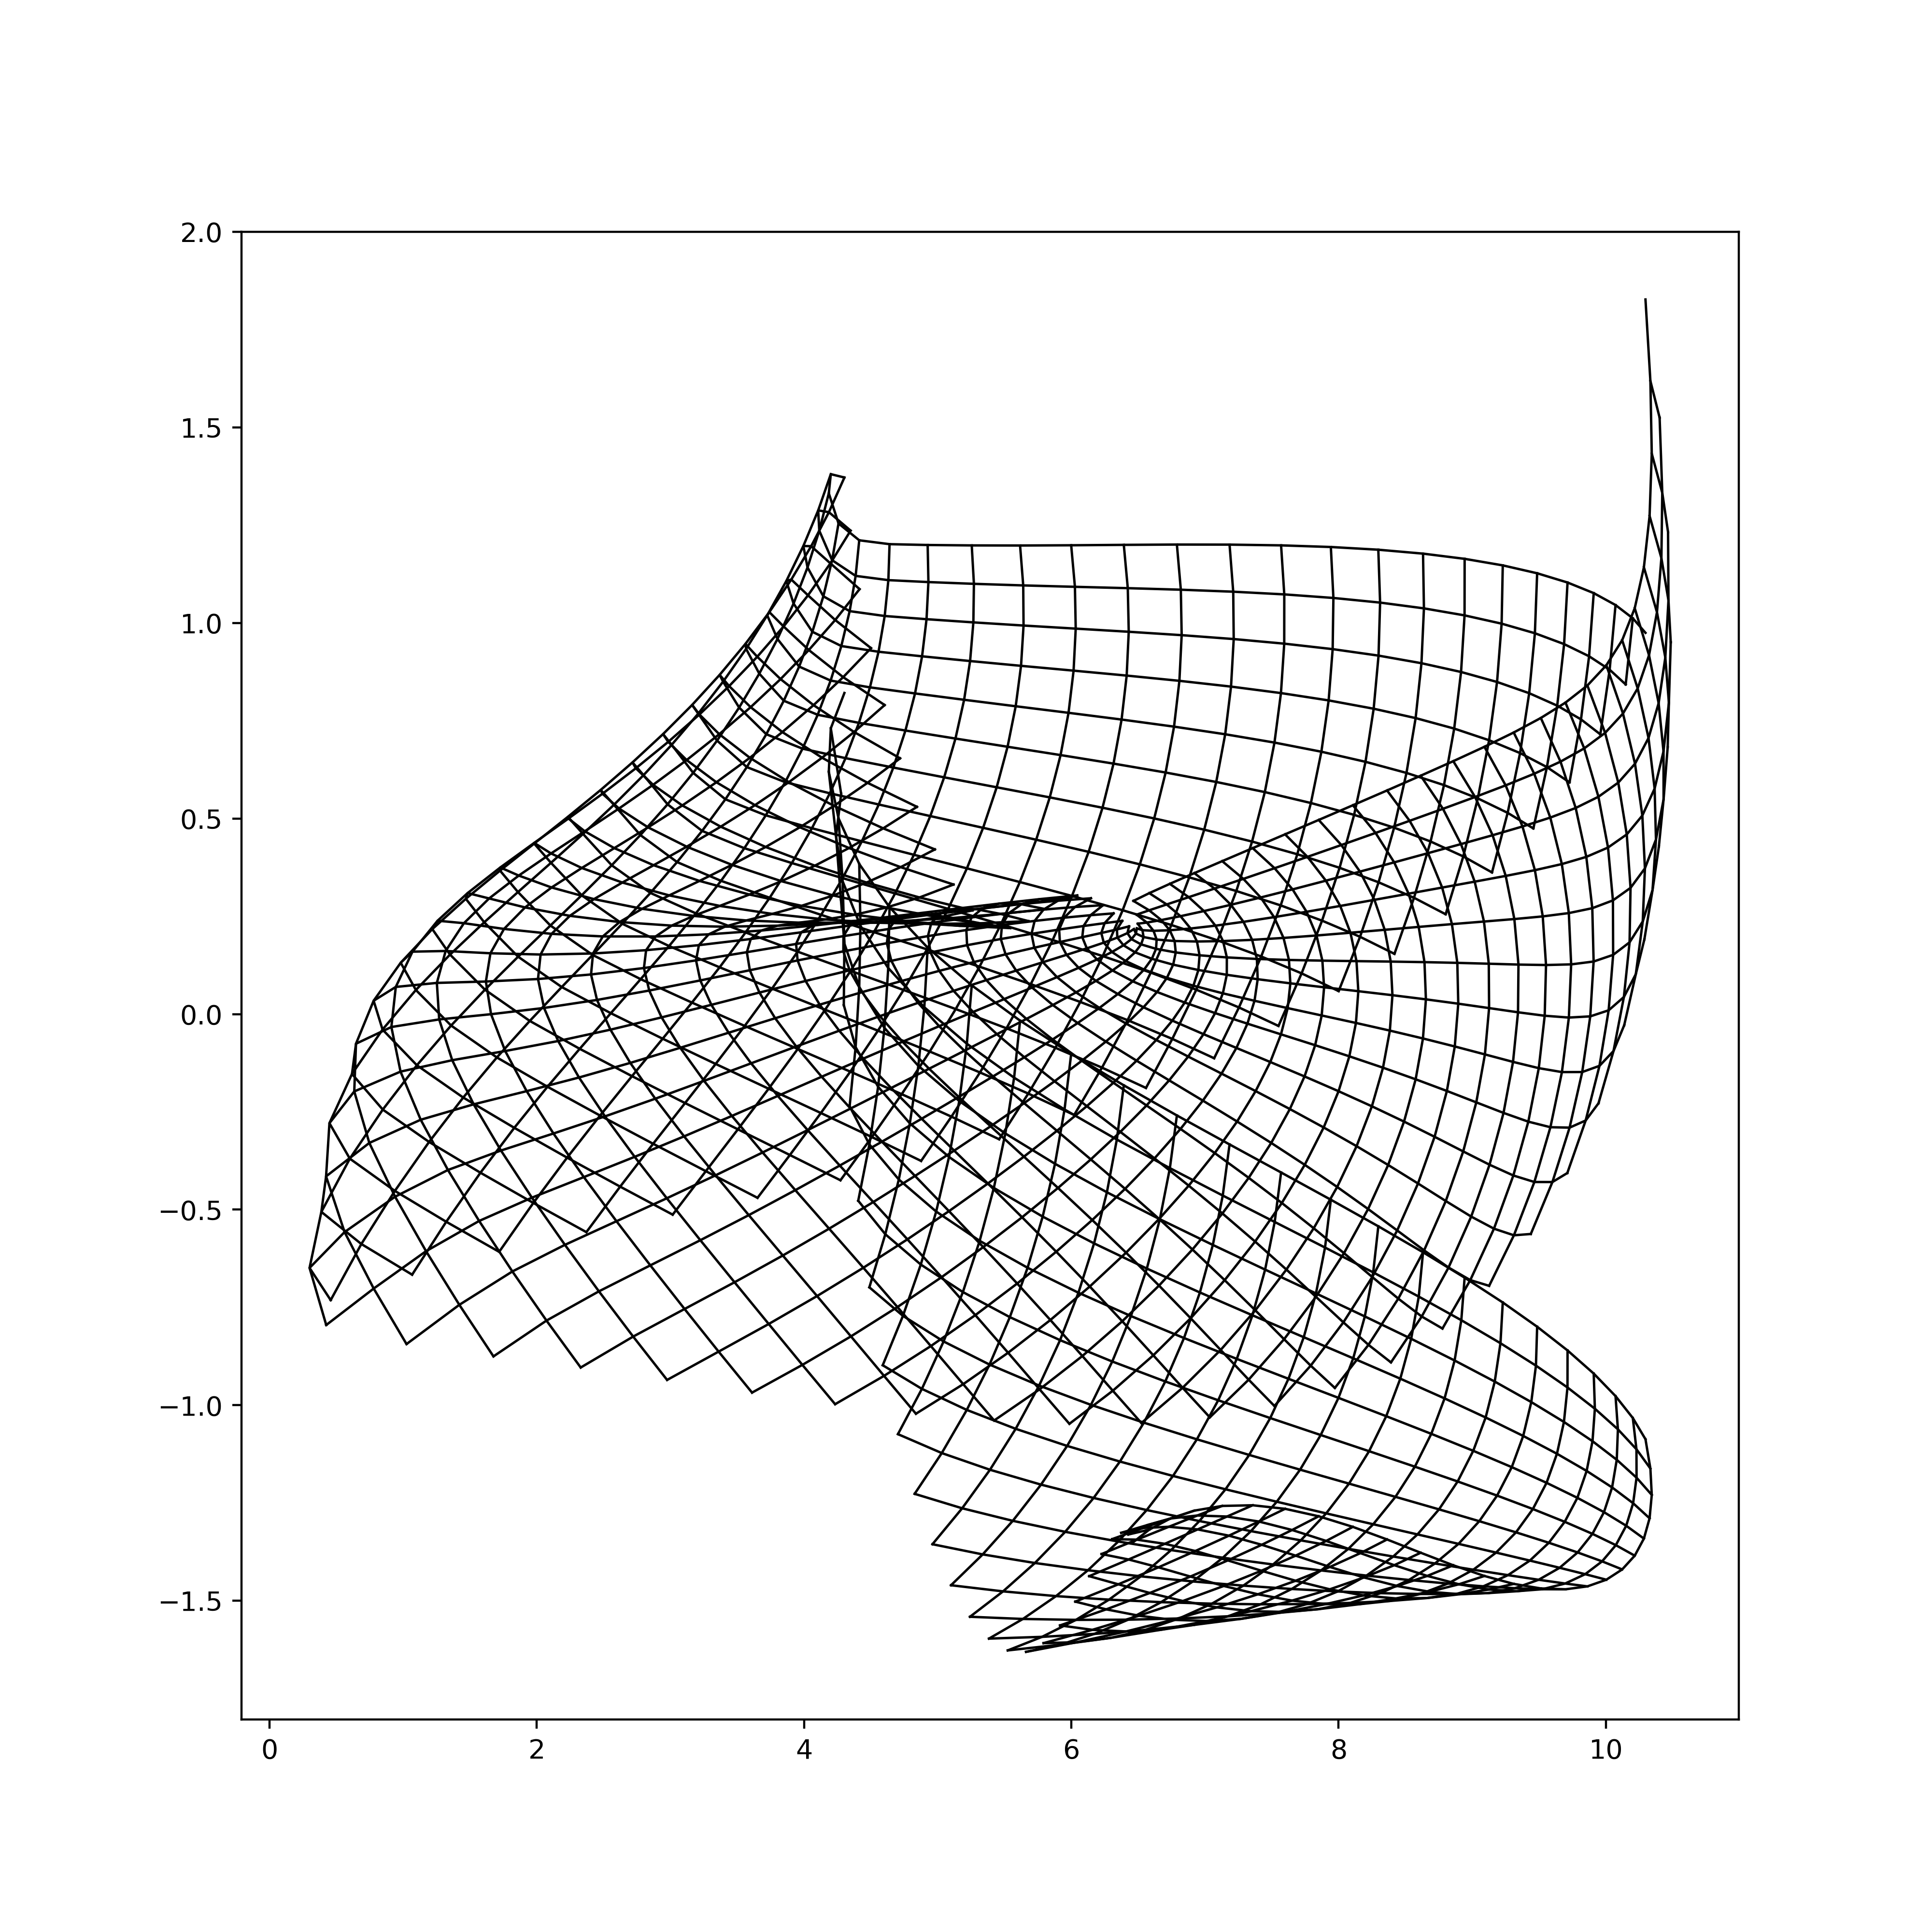

In [38]:
mapping_functions = (model.theta_1_single, model.theta_2_single)
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, mapping_functions=mapping_functions)
th_plotter.make_figure("theta_learned_5_2_image.png")
th_plotter.make_animation("theta_learned_5_2.mp4", duration = 4, fps = 20, stride = 1)

In [10]:
epoch = 1
plotters.plot_decoupling(model, device, rp, epoch)

ValueError: too many values to unpack (expected 4)

In [ ]:
q_test = torch.tensor([[2, -0.]]).to(device)
theta, J_h, q_hat, J_h_ana = model(q_test)

J_h_inv = torch.linalg.pinv(J_h)
J_h_inv_trans = J_h_inv.transpose(1, 2)




print("J_h:\n", J_h.detach().cpu().numpy()[0])
print("J_h_inv:\n", J_h_inv.detach().cpu().numpy()[0])

M_q, C_q, G_q = dynamics.dynamical_matrices(rp, q_test[0], q_test[0])
M_q = M_q.unsqueeze(0)
M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)
print("M_q:", M_q)
print("M_th:\n", M_th)


off_dia = M_th[:, 1,0]
diag_elements = M_th[:, [0, 1], [0, 1]]
diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1] + 1e-6)
M_th_ratio = off_dia/diag_product
print("M_th_ratio:", M_th_ratio)

print("M_q:\n", M_q)

print("J_h_ana:\n", J_h_ana.detach().cpu().numpy()[0], "\n")
J_h_ana_inv = torch.linalg.pinv(J_h_ana)
J_h_ana_inv_trans = J_h_ana_inv.transpose(1,2)

print("J_h_ana_inv:\n", J_h_ana_inv.detach().cpu().numpy()[0], "\n")


M_th_ana, C_th_ana, G_th_ana = dynamics.dynamical_matrices_th(rp, q_test[0], q_test[0]) 
print("M_th_ana:", M_th_ana.detach().cpu().numpy())

In [ ]:
# Extract epochs and losses
epochs = [entry[0] for entry in outputs]
losses = [entry[1].item() for entry in outputs]

# Plot loss as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import random
import string

max_neurons = 4
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()

In [ ]:
class Autoencoder2(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            #nn.Sigmoid(),
            #nn.Linear(4, 4)
        )
        
        
        self.decoder = nn.Sequential(
            #nn.Linear(4, 4),
            #nn.Sigmoid(),
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 2)
        )
        
        self.rp = rp

    def encoder_nn(self, q):
        latent = self.encoder(q)
        J_h_inv_1 = latent[:,0:2]
        J_h_inv_2 = latent[:,2:4]
        J_h_inv = torch.stack((J_h_inv_1, J_h_inv_2), dim=1)
        return J_h_inv, latent
    
    def forward(self, q):
        J_h_inv, latent = self.encoder_nn(q)

        q_hat = self.decoder(latent)
        return J_h_inv, q_hat

In [ ]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)

load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 2401

print(file_path)
model = Autoencoder2(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-6)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.99, eps=1e-08)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / num_epochs))



l_weights = [1,
             1,
             1e-1,
             1e-2]
outputs = []



plt.ion()

for epoch in range(num_epochs):
    for index, batch in enumerate(train_dataloader):
        batch_size = batch[0].shape[0]
        q = batch[0][:, 0:2].to(device)
        q.requires_grad = True
        q_d = batch[0][:, 2:4].to(device)
        
        J_h_inv, q_hat = model(q)  
        J_h_inv_trans = J_h_inv.transpose(1,2)
                
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, 
                                   in_dims=(None, 0, 0))

        M_q, C_q, G_q = matrices_vmap(rp, q, q_d)
        
        M_th, C_th, G_th = transforms.transform_dynamical_from_inverse(M_q, C_q, G_q, J_h_inv, J_h_inv_trans)      
        
        #loss_reconstruction = loss_terms.loss_reconstruction(q, q_hat)
        loss_diagonality_geo_mean = loss_terms.loss_diagonality_geo_mean(M_th, batch_size, device)
        loss_diagonality_trace = loss_terms.loss_diagonality_trace(M_th, batch_size, device)
        loss_diagonality_smallest = loss_terms.loss_diagonality_smallest(M_th, batch_size, device)
        ### Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        #loss_J_h_unitary = loss_terms.loss_J_h_unitary(J_h, batch_size, device)
        #loss_J_h_cheat = loss_terms.loss_J_h_cheat(J_h, J_h_ana)
        #loss_M_th_cheat = loss_terms.loss_M_th_cheat(M_th, rp, q, q_d, batch_size)
        #l1_norm = loss_terms.loss_l1(model)
        
        #loss_diagonality = 10 * loss_diagonality_geo_mean + loss_diagonality_smallest + 100 * loss_diagonality_trace
        loss_diagonality = loss_diagonality_geo_mean


        loss = loss_diagonality #+ 0.2 * loss_J_h_unitary

        
        #loss = loss_J_h_cheat


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

 

    if epoch % 400 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
        print("Weighted loss_diagonality_geo_mean:", loss_diagonality_geo_mean)
        #print("Weighted loss_diagonality_smallest:", loss_diagonality_smallest)
        #print("Weighted loss_diagonality_trace:", 100 * loss_diagonality_trace)
        #print("Weighted loss Jh unitary:", 0.2 * loss_J_h_unitary)
    if epoch % 1200 == 0 and epoch > 0:
        #plotters.plot_h2(model, device, rp, epoch)
        #plotters.plot_J_h(model, device, rp, epoch, plot_index = 0)
        #plotters.plot_J_h(model, device, rp, epoch, plot_index = 1)
        plotters.plot_decoupling_inv(model, device, rp, epoch)
    scheduler.step()

    outputs.append((epoch, loss, q, q_hat, J_h_inv, M_th))


torch.save(model.state_dict(), file_path)
print(f"Model parameters saved to {file_path}")